# Demand Forecasting


In [ ]:
# Store Item Demand Forecasting Challenge
# https://www.kaggle.com/c/demand-forecasting-kernels-only


In [1]:
!pip install lightgbm

In [2]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [7]:
# Loading the data
train = pd.read_csv("C:/Users/esman/OneDrive/Masaüstü/time_series/datasets/demand_forecasting/train.csv", parse_dates=['date'])
train 

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [8]:
test = pd.read_csv("C:/Users/esman/OneDrive/Masaüstü/time_series/datasets/demand_forecasting/test.csv", parse_dates=['date'])
test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [9]:
sample_sub = pd.read_csv("C:/Users/esman/OneDrive/Masaüstü/time_series/datasets/demand_forecasting/sample_submission.csv")
sample_sub 

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52
...,...,...
44995,44995,52
44996,44996,52
44997,44997,52
44998,44998,52


train setinde 4 değişken var --> date	store	item	sales
- train setinde model kuracağım.

test setinde ise --> date	store	item  
- sales yok, işte bunu ben tahmin edeceğim.

sample_sub --> id	sales 
- biz buradaki sales değerlerini değiştireceğiz ve kaggle yüklüycez.

In [6]:
#veri ön işleme ve değişken mühendisliği işlmelerini yapacağım için iki veri setini birlelştiriyorum.
df = pd.concat([train, test], sort=False)


# EDA


In [11]:
#veri setindeki min (ilk tarih) ve max (son) tarihi öğrenmek istiyorum.
df["date"].min(), df["date"].max()


(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

şimdi biz train ve test setini birleştirmiştik. test seti son 3 ay olduğuna göre, çünkü amacım 3 ayı tahmin etmekti. bu durumda test seti 2018 yılının ilk 3 ayıdır. train seti ise budnan önceki aylardır. 

In [12]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

veriye head attığımızda id kısmının NaN olduğu görülür. çünkü trains etinde ID diye bir değişken yok. Tail attığında ID vardır. çünkü test setinde ID ler vardı. 

Sales değişkenindeki mantıkda aynı. 
yani kısacası veri setlerini birleştirdik. birbirinde olmayanlar NaN üretmiş. 

In [13]:
#Veri setinde 10 mağaza vardı.
df[["store"]].nunique()


store    10
dtype: int64

In [14]:
#veri setinde 50 ürün vardı.
df[["item"]].nunique()


item    50
dtype: int64

In [15]:
# mağaza ürün kırılımınadki eşsiz değer sayısına bakalım. 
# Acaba her mağazada 50 ürün satılıyor mu?
df.groupby(["store"])["item"].nunique()


store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

buradan sonuçla şunu anlıyorum 10 mağazanın hepsine bu 50 üründe gitmiş. ve en az 1 tanesi satılmış olduğunu düşünüyorum..

In [16]:
#her mağazada bu ürünlerden kaçar tane satıldı.
df.groupby(["store", "item"]).agg({"sales": ["sum"]})


sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

- 1.mağazadaki  1.üründen --> 36468.0 kadar satılmış, 2.üründen -->97050.0 kadar satılmış.....

- 10.mağazadaki 49.üründen	60317.0 kadar satılmış. 

her ürünün mağaza özelinde kaç tane satıldığını görebiliyorum.

In [17]:
#mağaza ürün kırılımında satış istatistiklerini değerlendirelim.
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})


sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [18]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


# FEATURE ENGINEERING
(Değişken Mühendisliği)

In [19]:
df.head()


,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [20]:
#date değişkeninden üreteceğimiz yeni değişkenler;

def create_date_features(df):
    df['month'] = df.date.dt.month              #ay bilgisi
    df['day_of_month'] = df.date.dt.day         #ayın hangi günü
    df['day_of_year'] = df.date.dt.dayofyear    #yılın hangi günü
    df['week_of_year'] = df.date.dt.weekofyear  #yılın hangi haftası 
    df['day_of_week'] = df.date.dt.dayofweek    #haftanın hangi günü
    df['year'] = df.date.dt.year                #yıl bilgisi   
    df["is_wknd"] = df.date.dt.weekday // 4     #hafta sonu mu, değil mi?
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)  #ayın başlangıcı mı?
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)      #ayın sonu mu?
    return df

- Yapacağın tahmin hangi sektöre aitse o sektörün takvim bilgisini bilmelisin. mesela bir kırtasiye satışlarını düşürsek okulun açıldığı haftalarda yüksek ürün satışı gerçekleşir. ama okulun son haftalarında satış az olur.
- bir otel rezervasyonu için; özel günlerde (bayram, sevgililer günü vs, tatil zamanları vs.) satış daha fazladır gibi. bu tarihleri bu takvimi sektör özelinde bilmen gerekiyor. 
- özelikle bir "TALEP TAHMİN MODELİ" geliştiriyorsan, bu takvim bilgisini bilmelisin. bu bilgiyle bir değişken oluşturup modele eklemek zorundasın. çünkü bu değişkenin bir açıklayıcılığı bir ayırt ediciliği olacak.
- veri setinin içinden çeşitli trend ve mevsimsellikleri çıkaran "create_date_features" fonksiyonunu yazıyorum.

In [23]:
df = create_date_features(df)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0


In [24]:
#mağaza ürün ay kırlımında satışların istatistiklerini getiriyorum.
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})


sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

her mağazada bulunan ürünlerin aylara göre satış istatistikleri geldi.

# Random Noise
Rastgele gürültü üretecek bir fonksiyon tanımlıyorum --> random_noise

Üretecek olduğumuz gecikme featureları (Lag/Shifted Features) bağımlı değişken (sales) üzerinden üretilecek. burada aşırı öğrenmenin önüne geçmek için veri setine rastgele gürültü ekleyeceğim.


In [25]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Lag/Shifted Features (Gecikme Değişkenleri = geçmiş gerçek değerler)


In [27]:
#geçmiş dönem satış sayılarına ilişkin features üreteceğim. 
#bu featurelarda sales değişkeninin önceki dönemlere ilişkin değerleri olacak.
#bunun için mağaza ürün ve trihe göre sıralma olmalı ki gecikme değerleri doğru hesaplansın
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)


In [28]:
#shift fonksiyonu ile gecikmeler hesaplanır.
pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


sales = yt
lag1 = yt-1
lag2 = yt-2
ZAMAN SERİLERİ metin belgesine bak açıklaması orada.

In [29]:
#Mağaza ürün kırılımındaki satışları inceleyelim.
df.groupby(["store", "item"])['sales'].head()


0         13.0
1         11.0
2         14.0
3         13.0
4         10.0
          ... 
911174    33.0
911175    37.0
911176    46.0
911177    51.0
911178    41.0
Name: sales, Length: 2500, dtype: float64

In [30]:
#shift 1 i buraya uygula
df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))


0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

In [31]:
#geçmişe yönelik olarak çeşitli features üreteceğim ama kaç gecikme olacak?
#farklı gecikme değerleri gireceğim, bunlarda gezecek ve oluşturulan yeni featurelar "sales_lag_+ str(lag)" dinamik olarak isimlendirilecek.
# üzerine rastgele bir gürültü ekleyerek aşırı öğrenmenin önüne geçerek yeni features üreteceğiz.

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [32]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])


In [33]:
check_df(df)


##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int32
is_month_end               int32
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

sales_lag_91: 3 ay öncesine ilişkin geçmiş gerçek değer.
sales_lag_98: 3 ay 1 hafta öncesine ilişkin geçmiş gerçek değer.

- Buralarda 3 ayın katları olacak şekilde gerideki değerlere bakıyorum. çünkü amacım 3 ay sonrasını tahmin edebilmek. başarılı bir tahmin yapabilmek içn 3 ay öncesi verilere bak.
- burada eksik değerler de var ama ağaca dayalı yöntemleri kullancağım için bu sorun yaratmaycak.

# Rolling Mean Features
 (Hareketli Ortalama Özellikleri)
 Hareketli ortalama features üretmek için rolling methodu kullanılır.
 kaç adım gidileceğide window argümanına belirtilir.
 
 roll 2: geçmiş 2 değerin (kendisi dahil) ortalaması
 roll 5: geçmiş 5 değerin (kendisi dahil)ortalamsı...
 
 burada kendisini dahil etmesi sıkıntılı. çünkü ben yarının değerlerini tahmin edeceksem; yarının değerleir dahil o.ü. geçmiş 2 değerine gidebilme şansım var mı? Elimde yarının değeri yok, bu mümkün değildir. İŞte bu tuzaktan kurtulmak için mutlaka 1 tande shift almalıyız ki bu kendini dahil etme durumundan kurtulalım.

In [34]:

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,12.0,NaN,NaN
2,14.0,12.5,12.666667,NaN
3,13.0,13.5,12.666667,NaN
4,10.0,11.5,12.333333,12.2
5,12.0,11.0,11.666667,12.0
6,10.0,11.0,10.666667,11.8
7,9.0,9.5,10.333333,10.8
8,12.0,10.5,10.333333,10.6
9,9.0,10.5,10.000000,10.4


- 1.indexdeki salesa bak. 11. 11 kendiside dahil olmak üzere 1 önceki deperine git, 13. roll 2 değeri için bu 2 değerin ortalamsını al, 12. 

- 4. indexin sales değişkenine bak, 10. roll 2 için bir önceki değere bak ve ikisinin ortalamasını al  (10+13/2), 11,5. roll 3 için 10+13+14/3 = 12.33 gibi....

In [35]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})



,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


In [36]:
#windowlarda gezi yine dinamik isimlednirme var, shift al ve hesaplama işlemi
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [38]:
#burada 1 yıl öncesine (365 gün) ilişkin bilgiyi ve 1.5 yıl (546 gün) öncesine ilişkin bilgiyi veriye yansıtmaya çalışıyorum. 
df = roll_mean_features(df, [365, 546])
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,39.541014,51.025249,64.363393,68.145450,66.629343,81.425871,78.688029,57.431284,95.141475,72.295880,90.070361,88.360046
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,60.460979,49.008261,66.785891,61.023153,76.585854,80.919913,79.964201,75.711900,78.246335,65.591223,88.416384,86.432141
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,57.571046,64.710566,68.518985,64.855870,72.856361,84.516054,84.481011,65.726221,96.681914,74.682635,86.461922,87.751159
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,73.617543,73.543316,70.211720,67.982214,66.848535,81.159427,90.507978,67.677585,74.822144,85.777851,86.571855,84.862039


# Exponentially Weighted Mean Features
Üstel Ağırlıklı Ortalama Özellikleri

In [39]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})


,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.947368
3,13.0,12.5,13.970201,13.855107,13.287770,12.704797
4,10.0,13.5,13.009702,13.042750,13.084686,12.790637
5,12.0,11.5,10.030097,10.152137,10.920146,12.109179
6,10.0,11.0,11.980301,11.907607,11.676595,12.085878
7,9.0,11.0,10.019803,10.095380,10.502722,11.686057
8,12.0,9.5,9.010198,9.054769,9.450748,11.214433
9,9.0,10.5,11.970102,11.852738,11.235259,11.342672


ewm099 : ALFA DEĞERİ 99
ALFA DEĞERİ AZALDIKÇA ÇIKAN SONUÇ HAREKETLİ ORTALAMA DEĞERİNE (roll2) YAKIN OLACAKTIR.
* Alfa kaç olacak buna karar vermeliyim, ve bunlara verilecek ağırlıklarıda belirlemeliyim.

In [40]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [41]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]


In [42]:
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]


In [44]:
#ilgili alfa ve gecikmelere göre df şekillendir.
df = ewm_features(df, alphas, lags)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,39.541014,51.025249,64.363393,68.145450,66.629343,81.425871,78.688029,57.431284,95.141475,72.295880,90.070361,88.360046,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,60.460979,49.008261,66.785891,61.023153,76.585854,80.919913,79.964201,75.711900,78.246335,65.591223,88.416384,86.432141,61.928089

In [45]:
check_df(df)


##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sale

# One-Hot Encoding
Veri setinde var olan kategorik değişkenleri one hot encoderdan geçireceğiz.


In [46]:
#girilen değişkenleri get_dummies ile ohe geçiriyorum.
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])


In [47]:
check_df(df)


##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date  sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_2

146 değişkenim var, en başta 4 idi.

# Converting sales to log(1+sales)
- Bağımlı değişkenin logaritmasını alacağız. çünkü lightgbm modeli gradient descent temellidir ve bağımlı değişkenimiz (sales) sayısaldır. iterasyon işlmelerinin süresi, tehmin edilen değerlerle - artıkların etkileşiminden kaynaklandığı için böyle bir standartlaştırma yapıyoruz. iterasyon işlemi daha kısa sürsün diye.

- yani normalde ağaç yöntemlerinde değişkenlerde standartlaştırma yapmak zorunda değiliz, sınıfladnırma problemlerinde de yapmasak olur.

In [48]:
df['sales'] = np.log1p(df["sales"].values)


In [49]:
check_df(df)


##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date     sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_la

#                               # MODEL

# Custom Cost Function
- MAE, MSE, RMSE, SSE

- MAE: mean absolute error
- MAPE: mean absolute percentage error
- SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
Smape nedir ayrıntı için metin belgesine bak.

In [50]:
#smape formülasyonu ifade edelim.
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


In [51]:
#labels: gerçek değerler ile preds: tahmin edilen değerleri kıyaslayacağız. ve smape score hesaplanır.
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False



# Time-Based Validation Sets
Zamana Dayalı Doğrulama Kümeleri 
train setinde modeli eğitiyorum. test etmek içinde bir validation set oluşturacağım.

KAGGLE, 2018 yılının ilk 3 ayının thaminlerini istiyor. bende bu isteğe en uygun olacak şekilde bir validation set oluşturacağım. bunun için 2017 yılının ilk 3 ayını alıyorum ve bunu valıdation set olarak belirliyorum.
bu durumda train setim 2016 nın sonuna kadar olacak. yanı 2017 nin başı olan ilk 3 ayı içermeyecek.

- şimdi train ile eğiticemi validation ile doğrulayacağım, test setini tahmin edicem. 

modelin görmediği veride modeli değerlendirmek için bir validation set oluşturuyorum.

In [53]:
# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

In [54]:
# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [61]:
#bağımsız değişkenleri seç
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]
cols

['day_of_month',
 'day_of_year',
 'week_of_year',
 'is_wknd',
 'is_month_start',
 'is_month_end',
 'sales_lag_91',
 'sales_lag_98',
 'sales_lag_105',
 'sales_lag_112',
 'sales_lag_119',
 'sales_lag_126',
 'sales_lag_182',
 'sales_lag_364',
 'sales_lag_546',
 'sales_lag_728',
 'sales_roll_mean_365',
 'sales_roll_mean_546',
 'sales_ewm_alpha_095_lag_91',
 'sales_ewm_alpha_095_lag_98',
 'sales_ewm_alpha_095_lag_105',
 'sales_ewm_alpha_095_lag_112',
 'sales_ewm_alpha_095_lag_180',
 'sales_ewm_alpha_095_lag_270',
 'sales_ewm_alpha_095_lag_365',
 'sales_ewm_alpha_095_lag_546',
 'sales_ewm_alpha_095_lag_728',
 'sales_ewm_alpha_09_lag_91',
 'sales_ewm_alpha_09_lag_98',
 'sales_ewm_alpha_09_lag_105',
 'sales_ewm_alpha_09_lag_112',
 'sales_ewm_alpha_09_lag_180',
 'sales_ewm_alpha_09_lag_270',
 'sales_ewm_alpha_09_lag_365',
 'sales_ewm_alpha_09_lag_546',
 'sales_ewm_alpha_09_lag_728',
 'sales_ewm_alpha_08_lag_91',
 'sales_ewm_alpha_08_lag_98',
 'sales_ewm_alpha_08_lag_105',
 'sales_ewm_alpha_08_l

In [62]:
#train seti için bağımlı değişken
Y_train = train['sales']


In [63]:
#train seti için bğaımsız değişken
X_train = train[cols]


In [64]:
#validation set için bağımlı değişken
Y_val = val['sales']


In [65]:
#validation set için bağımsız değişkenler
X_val = val[cols]


In [66]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((730500,), (730500, 142), (45000,), (45000, 142))

# LightGBM ile Zaman Serisi Modeli
 !pip install lightgbm
 conda install lightgbm
 
lightgbm, ağaca dayalı makine öğrenimi yöntemlerinden biri.

In [67]:
# LightGBM parameters
#buradaki parametre değerleir öncesinden en doğrusu aranarak yazılmıştır. g
#grid_Search_Cv ile bu hiperparametrelerin en doğru değerleri bulundu.
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,   #iterasyon sayısı
              'early_stopping_rounds': 200,
              'nthread': -1}

In [68]:
#lgb özel veri yapısı kullanılır. lgb.dataset kullanılır. böylece train set oluştuurulur.
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)


In [69]:
#lgbm validation set oluşturulur.
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)


In [70]:
# modelleme de fit yerine lbg.train kullanılmaktadır.
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'], #belirli bir iterasyondan sonra başarı değeri artmazsa ilerlemyi durdur.
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.313182 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0512974	training's SMAPE: 17.5875	valid_1's l2: 0.0530805	valid_1's SMAPE: 17.441
[200]	training's l2: 0.0352011	training's SMAPE: 14.5639	valid_1's l2: 0.0371693	valid_1's SMAPE: 14.919
[300]	training's l2: 0.0324081	training's SMAPE: 14.0049	valid_1's l2: 0.0342176	valid_1's SMAPE: 14.455
[400]	training's l2: 0.0313494	training's SMAPE: 13.7898	valid_1's l2: 0.0333554	valid_1's SMAPE: 14.3023
[500]	training's l2: 0.0306824	training's SMAPE: 13.6583	valid_1's l2: 0.0328085	valid_1's SMAPE: 14.1823
[600]	training's l2: 0.0302221	training's SMAPE: 13.5643	valid_1's l2: 0.0323093	valid_1's SMAPE: 14.0631
[700]	training's l2: 0.0298812	training's SMAPE: 13.4943	valid_1's l2: 0.0319832	valid_1's SMAPE: 13.9882
[800]	training's l2: 0.0295874	tra

early_stopping_rounds; train süresini kısaltır. aşırı öğrenmenin önüne geçer.
model karmaşıklığını optimum noktada bırakarak aşırı öğrenmenin önüne geçiyoruz. bunun için; validasyon hatasının eğitim hatasına kıyasla düşmeye başladığı yerde model karmaşıklığını duruduyourm.

burada lightgm de num_boost_round değerini en az 10000 den başlatmalıyız. ve bu iterasyon boyuncada en iyi değerler aranır. 

In [73]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)


In [74]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))


13.84920517364192

# Değişken Önem Düzeyleri


In [75]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

                        feature  split       gain
17          sales_roll_mean_546    921  54.521485
13                sales_lag_364   1246  13.182604
16          sales_roll_mean_365    625   9.813812
60   sales_ewm_alpha_05_lag_365    363   4.894283
18   sales_ewm_alpha_095_lag_91    111   2.325959
..                          ...    ...        ...
115                     item_43      0   0.000000
96                      item_24      0   0.000000
118                     item_46      0   0.000000
72                     store_10      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


,feature,split,gain
17,sales_roll_mean_546,921,54.521485
13,sales_lag_364,1246,13.182604
16,sales_roll_mean_365,625,9.813812
60,sales_ewm_alpha_05_lag_365,363,4.894283
18,sales_ewm_alpha_095_lag_91,111,2.325959
...,...,...,...
115,item_43,0,0.000000
96,item_24,0,0.000000
118,item_46,0,0.000000
72,store_10,0,0.000000


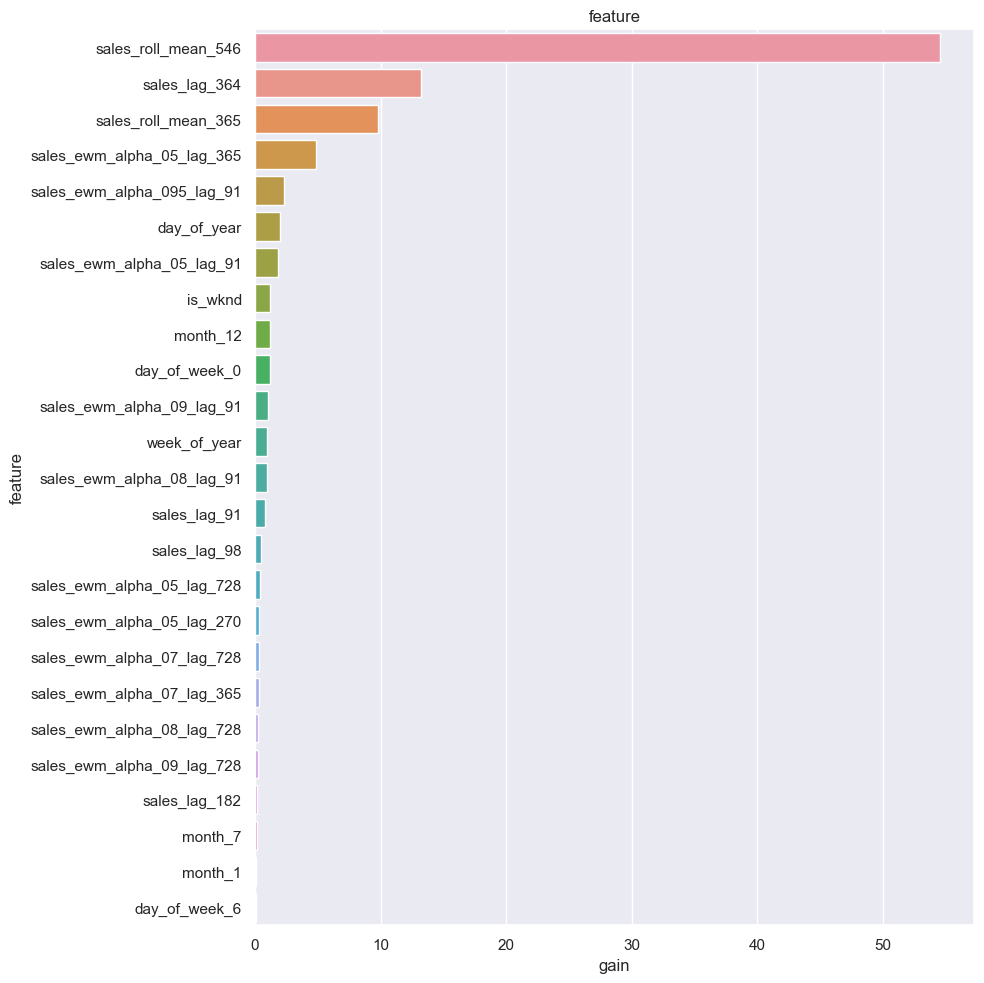

,feature,split,gain
17,sales_roll_mean_546,921,54.521485
13,sales_lag_364,1246,13.182604
16,sales_roll_mean_365,625,9.813812
60,sales_ewm_alpha_05_lag_365,363,4.894283
18,sales_ewm_alpha_095_lag_91,111,2.325959
...,...,...,...
115,item_43,0,0.000000
96,item_24,0,0.000000
118,item_46,0,0.000000
72,store_10,0,0.000000


In [76]:
#kaç değişkeni gösterek istiyorsan num ile ifade edilir.
plot_lgb_importances(model, num=30, plot=True)


bir ağaç yönteminde değişken öenmli olması = bölünme işlemi sonrasında hatada kazandırdığı değerdir. bölünme öncesi ve sonrası entropi değeridir.
bir feature kaç defa bölme işlemlerinde kullanıldı. yukarıdaki tabloda split değerlerine bak. bir değişkenin kaç kere bölündüğünü görebilirsin.

In [77]:
feat_imp = plot_lgb_importances(model, num=200)


                        feature  split       gain
17          sales_roll_mean_546    921  54.521485
13                sales_lag_364   1246  13.182604
16          sales_roll_mean_365    625   9.813812
60   sales_ewm_alpha_05_lag_365    363   4.894283
18   sales_ewm_alpha_095_lag_91    111   2.325959
..                          ...    ...        ...
115                     item_43      0   0.000000
96                      item_24      0   0.000000
118                     item_46      0   0.000000
72                     store_10      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


In [78]:
#importence 0 olan değişkenler
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values


In [79]:
# importance skoru 0 olmayanları seç
imp_feats = [col for col in cols if col not in importance_zero]


In [80]:
# 111 tane değişkenin önem düzeyi 0 değil.
len(imp_feats)


111

# Final Model


In [81]:
train = df.loc[~df.sales.isna()]


In [82]:
Y_train = train['sales']

In [83]:
X_train = train[cols]


In [85]:
#sales boş olanları test seti idi.
test = df.loc[df.sales.isna()]


In [86]:
X_test = test[cols]


In [89]:
#en iyi iterasyon adedeini biliyorum artık. bunu giriyoum.
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [90]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)


In [93]:

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.256695 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [94]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

# Submission File
Kaggle dosyayı gönderme

In [95]:
test.head()


,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,11.294474,13.995469,22.763876,15.829522,11.637180,16.561146,18.959540,18.121572,16.837343,12.586634,23.380636,23.529509,12.472220,14.531325,22.392609,16.695005,22.989955,24.801901,18.774592,18.843644,12.003480,12.987531,15.120201,22.770677,17.380051,22.969272,24.605438,18.596446,19.678303,12.017666,14.136684,16.435296,23.481072,18.719979,22.948070,24.207259,18.366501,21.332981,12.097977,15.418629,17.863610,24.114316,20.015174,23.029458,23.791446,18.268850,22.964410,12.271265,18.192747,20.671654,24.971733,22.381769,23.804594,22.867776,18.234876,25.986567,12.903982,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,15.533655,18.973043,23.018084,19.516441,24.903240,20.708563,24.742463,12.292954,28.460989,9.572208,24.995822,21.882327,17.723611,17.826566,21.069630,19.834750,30.599498,24.990095,15.188730,30.392182,12.000174,17.498753,17.712020,21.177068,19.738005,30.196927,24.960544,15.359645,29.867830,12.001767,17.227337,17.687059,21.496214,19.743996,29.389614,24.841452,15.673300,29.066596,12.019595,17.225589,17.959083,21.934295,20.004552,28.608837,24.637434,15.980655,28.589323,12.081380,18.096374,19.335827,22.985866,21.190884,27.402297,23.933888,16.617438,28.493284,12.451991,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,NaN,2.0,3,3,1,2018,0,0,0,14.739131,26.190374,19.137707,15.288671,25.615197,21.423709,23.170058,14.289052,24.831286,16.079871,21.332347,23.665984,15.136181,26.541328,20.053482,13.341738,31.929975,23.099505,10.259436,22.419609,15.800009,15.249875,26.071202,20.117707,13.673801,31.819693,23.196054,10.535

In [96]:
#tüm satırlar gelsin ama sütunlardan sadece id ve sales değişkenleri gelsin.
submission_df = test.loc[:, ["id", "sales"]]
submission_df

In [100]:
#sales yerine kendi tahmin ettiklerimi giriyorum.
submission_df['sales'] = np.expm1(test_preds)
submission_df

,id,sales
0,0,13.468179
1,1,14.109522
2,2,14.247476
3,3,14.630639
4,4,18.078123
...,...,...
44995,44995,68.658050
44996,44996,75.507670
44997,44997,76.866897
44998,44998,80.565013


In [98]:
submission_df['id'] = submission_df.id.astype(int)


In [101]:
#bu dosyayı csv formatına çevirmek için to_csv methodu kullanılır.
submission_df.to_csv("submission_demand.csv", index=False)
